In [187]:
import numpy as np
import scipy as sp
import scipy.linalg as la

import matplotlib.pyplot as plt

import os
import copy

import h5py

import ase

import BoltzTraP2.misc as BTmisc
import BoltzTraP2.bandlib as BL
import BoltzTraP2.io as IO
from BoltzTraP2.dft import register_loader, DFTData
from BoltzTraP2 import sphere
from BoltzTraP2 import fite
from BoltzTraP2 import serialization
from BoltzTraP2.misc import ffloat
from BoltzTraP2 import units
from BoltzTraP2.fd import FD, dFDde, _FD_XMAX

In [6]:
eV = 1/27.2114 # Hartee
Bohr__AA = 0.529177249 # Å
Angstrom = 1.0 / Bohr__AA
Picosecond = 1.
Kelvin = 1.

hbar = 6.582e-4 * eV * Picosecond
kB = 8.617e-5 * eV / Kelvin

In [9]:
basedir = '../examples/Graphene'

In [7]:
class DFTBEPHYLoader:
    """Simple loader for DFTB calculations."""

    def __init__(self, directory):
        # Check that the argument is a directory
        if not isinstance(directory, str):
            raise LoaderError("this loader only works with directories")

        datafn = 'relaxation-times.hdf5'
            
        # "cd" to the directory and check that all required files are present
        with BTmisc.dir_context(directory):
            if not os.path.isfile(datafn):
                raise LoaderError("Data file not found")
                
            with h5py.File(datafn, 'r') as f:
                sysname = f['struct'].attrs['name']
                BTmisc.info("DFTB system name:", sysname)                
                
                # k-point list,
                self.kpoints = f['el']['k-points'][()]
                # the band energies plus related parameters,
                self.ebands = f['el']['eps_kn'][()].T * eV
                self.fermi = f['el']['eps_kn'].attrs['EF'] * eV
                self.dosweight = 2.
                # and the momentum matrix elements
                self.mommat = f['el']['vel_kn'][()] * eV * Angstrom

                # Build the structural information,                
                cell = f['struct']['cell'][()] 
                positions = f['struct']['positions'][()] 
                numbers = f['struct']['numbers'][()] 
                self.atoms = ase.Atoms(positions=positions, numbers=numbers, cell=cell, pbc=[1, 1, 1])
                                
                # Finally, set the system name
                self.sysname = sysname
                
def read_taus(directory):
    # Check that the argument is a directory
    if not isinstance(directory, str):
        raise LoaderError("this loader only works with directories")

    datafn = 'relaxation-times.hdf5'

    # "cd" to the directory and check that all required files are present
    with BTmisc.dir_context(directory):
        if not os.path.isfile(datafn):
            raise LoaderError("Data file not found")

        with h5py.File(datafn, 'r') as f:
            sysname = f['struct'].attrs['name']
            BTmisc.info("DFTB system name:", sysname)                

            taus = hbar / (f['el-ph']['linewidths'][()].T * eV)
            kBTs = f['el-ph']['linewidths'].attrs['kBTs'] * eV
            mus = f['el-ph']['linewidths'].attrs['mus'] * eV

    return mus, kBTs, taus

def get_cell_area(data):
    cell = data.atoms.cell
    cell_area = np.linalg.norm(np.cross(cell[0],cell[1]))
    return cell_area*Angstrom**2

def get_cell_height(data):
    return data.atoms.cell[2,2]*Angstrom

In [8]:
register_loader("dftbephy", DFTBEPHYLoader)

In [215]:
data = DFTData(basedir+'/el-ph/', derivatives=True)
lattvec = data.get_lattvec()

# Select the interesting bands
ana=data.bandana(emin=data.fermi - 1.5*eV, emax=data.fermi + 1.5*eV)

In [216]:
data.ebands.shape

(2, 884)

In [217]:
niter = 120
radix = "graphene_BLZTRP"

equivalences = sphere.get_equivalences(data.atoms, data.magmom, niter * len(data.kpoints))
print("There are", len(equivalences), "equivalence classes in the output grid")

new_equivalences = []
for e in equivalences:
    if np.prod(e[:,2] == 0):
        new_equivalences.append(e)
        
print("But only", len(new_equivalences), "equivalence classes are in-plane")

coeffs = fite.fitde3D(data, new_equivalences)
# serialization.save_calculation(radix + ".bt2", data, equivalences, coeffs,
#                                serialization.gen_bt2_metadata(data, data.mommat is not None))

There are 111569 equivalence classes in the output grid
But only 6384 equivalence classes are in-plane


In [218]:
dims = 2 * np.max(np.abs(np.vstack(new_equivalences)), axis=0) + 1
dims

array([333, 333,   1], dtype=int32)

In [219]:
mus, kBTs, tausDFTB = read_taus(basedir+'/el-ph/')

In [220]:
eband, vvband, cband = fite.getBTPbands(new_equivalences, coeffs, lattvec, curvature=False)

In [221]:
npts = 200
epsilon, Cdos, Cvvdos, cdos = BL.BTPDOS(eband, vvband, npts=npts)

# Density of States, Transport Density of States

In [222]:
ibnd_VB = 0
ibnd_CB = 1

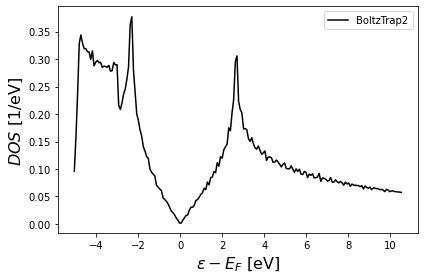

In [223]:
plt.plot((epsilon - data.fermi) / eV, Cdos * eV, "k-", label='BoltzTrap2')

#plt.axhline(y=2*0.04/(np.pi)/eV, color='grey')

plt.xlabel(r'$\epsilon - E_F$ [eV]', fontsize=16)
plt.ylabel(r'$DOS$ [1/eV]', fontsize=16)
plt.legend()
plt.tight_layout()
plt.show()
# plt.savefig('BT_DOS.pdf')

# Transport Properties

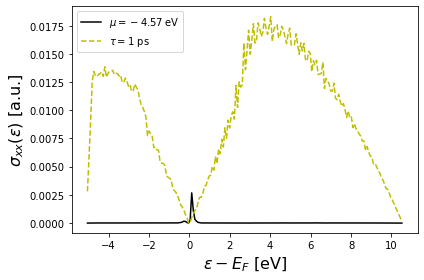

In [224]:
nc=15

pseudodata = copy.deepcopy(data)
pseudodata.ebands = tausDFTB[ana,:, nc]
pseudocoeffs = fite.fitde3D(pseudodata, new_equivalences)
tau = fite.getBTPbands(new_equivalences, pseudocoeffs, lattvec, curvature=False)[0]
epsilon, dos, vvdos, cdos = BL.BTPDOS(
    eband, vvband, npts=npts, scattering_model=tau
)

plt.plot((epsilon - data.fermi) / eV, vvdos[0,0] * eV, "k-", label=r'$\mu=%3.2f$ eV' % (mus[nc]/eV))
# plt.plot((epsilon - data.fermi) / eV, vvdos[0,0] * eV, "r-", label=r'$\mu=%3.2f$ eV' % (mus[0]/eV))

plt.plot((epsilon - data.fermi)/ eV , Cvvdos[0,0]  * eV , "y--", label=r'$\tau=1$ ps')

#plt.axvline(x=((data.ebands[1,:].max()-data.ebands[1,:].min())/4+data.ebands[1,:].min()- data.fermi) / eV, color='grey')
#plt.axvline(x=((data.ebands[0,:].min()-data.ebands[0,:].max())/4+data.ebands[0,:].max()- data.fermi) / eV, color='grey')
#plt.ylim((0,.03))

plt.xlabel(r'$\epsilon - E_F$ [eV]', fontsize=16)
plt.ylabel(r'$\sigma_{xx}(\epsilon)$ [a.u.]', fontsize=16)
plt.legend()
plt.tight_layout()

plt.show()
# plt.savefig('BT_transDOS_tauk.pdf')

In [212]:
nc=19

pseudodata = copy.deepcopy(data)
pseudodata.ebands = 1/tausDFTB[ana,:, nc]
pseudocoeffs = fite.fitde3D(pseudodata, new_equivalences)
tau = fite.getBTPbands(new_equivalences, pseudocoeffs, lattvec, curvature=False)[0]

(mus[nc]-data.fermi)

0.005512318433241237

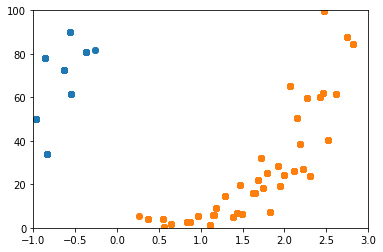

In [214]:
#plt.scatter((eband[ibnd_CB-2,:]- data.fermi)/eV, tau[ibnd_CB-2,:])
plt.scatter((eband[ibnd_CB-1,:]- data.fermi) / (mus[nc]-data.fermi), tau[ibnd_CB-1,:])
plt.scatter((eband[ibnd_CB,:]- data.fermi) / (mus[nc]-data.fermi), tau[ibnd_CB,:])
#plt.scatter((eband[ibnd_CB+1,:]- data.fermi)/eV, tau[ibnd_CB+1,:])

#plt.axvline(x=(mus[nc]-data.fermi)/eV)

#plt.gca().set_xscale('log')
#plt.gca().set_yscale('log')
plt.xlim((-1,3))
plt.ylim((0,100))
plt.show()

In [226]:
N, L0, L1, L2, Lm11 = BL.fermiintegrals(epsilon, Cdos, Cvvdos, mur=mus, Tr=[kBTs[0]/units.BOLTZMANN,])
Csigma, seebeck, kappa, Hall = BL.calc_Onsager_coefficients(
    L0, L1, L2, mus, np.array([kBTs[0]/units.BOLTZMANN,]), data.get_volume()
)

N, L0, L1, L2, Lm11 = BL.fermiintegrals(epsilon, dos, vvdos, mur=mus, Tr=[kBTs[0]/units.BOLTZMANN,])
sigma, seebeck, kappa, Hall = BL.calc_Onsager_coefficients(
    L0, L1, L2, mus, np.array([kBTs[0]/units.BOLTZMANN,]), data.get_volume()
)

In [225]:
N, L0, L1, L2, Lm11 = BL.fermiintegrals(epsilon, Cdos, Cvvdos, mur=mus, Tr=[kBTs[0]/units.BOLTZMANN,])
Csigma, seebeck, kappa, Hall = BL.calc_Onsager_coefficients(
    L0, L1, L2, mus, np.array([kBTs[0]/units.BOLTZMANN,]), data.get_volume()
)

trans_data = []
pseudodata = copy.deepcopy(data)
for nc, mu in enumerate(mus):
    print('-- working on mu=%3.2f eV' % (mu/eV))
    pseudodata.ebands = tausDFTB[ana,:, nc]
    pseudocoeffs = fite.fitde3D(pseudodata, new_equivalences)
    tau = fite.getBTPbands(new_equivalences, pseudocoeffs, lattvec, curvature=False)[0]
    epsilon, dos, vvdos, cdos = BL.BTPDOS(
        eband, vvband, npts=npts, scattering_model=tau
    )

    N, L0, L1, L2, Lm11 = BL.fermiintegrals(epsilon, dos, vvdos, mur=[mu,], Tr=[kBTs[0]/units.BOLTZMANN,])
    sigma, seebeck, kappa, Hall = BL.calc_Onsager_coefficients(
        L0, L1, L2, np.array([mu,]), np.array([kBTs[0]/units.BOLTZMANN,]), data.get_volume()
    )
    
    dens = -(data.nelect+N)/(data.get_volume()/get_cell_height(data))*Angstrom**2 * 1e16 # 1/cm^2
    
    trans_data.append([mu, kBTs[0], dens[0,0], sigma[0,0,0,0]*(data.atoms.cell[2,2]*1e-10) * 1e-12])
    
trans_data = np.array(trans_data)

-- working on mu=-4.81 eV
-- working on mu=-4.79 eV
-- working on mu=-4.78 eV
-- working on mu=-4.76 eV
-- working on mu=-4.75 eV
-- working on mu=-4.73 eV
-- working on mu=-4.71 eV
-- working on mu=-4.70 eV
-- working on mu=-4.68 eV
-- working on mu=-4.67 eV
-- working on mu=-4.65 eV
-- working on mu=-4.64 eV
-- working on mu=-4.62 eV
-- working on mu=-4.60 eV
-- working on mu=-4.59 eV
-- working on mu=-4.57 eV
-- working on mu=-4.56 eV
-- working on mu=-4.54 eV
-- working on mu=-4.53 eV
-- working on mu=-4.51 eV


In [228]:
trans_data

array([[-1.76747869e-01,  9.51806963e-04, -2.56918158e+12,
         1.59770785e-02],
       [-1.76167617e-01,  9.51806963e-04, -2.09368072e+12,
         2.42465815e-02],
       [-1.75587365e-01,  9.51806963e-04, -1.65075556e+12,
         3.42449774e-02],
       [-1.75007113e-01,  9.51806963e-04, -1.25452654e+12,
         3.89030597e-02],
       [-1.74426860e-01,  9.51806963e-04, -9.27204184e+11,
         3.37824479e-02],
       [-1.73846608e-01,  9.51806963e-04, -6.71970060e+11,
         2.29802076e-02],
       [-1.73266356e-01,  9.51806963e-04, -4.72527974e+11,
         1.30614608e-02],
       [-1.72686104e-01,  9.51806963e-04, -3.09775429e+11,
         6.58214112e-03],
       [-1.72105852e-01,  9.51806963e-04, -1.71748465e+11,
         3.09926482e-03],
       [-1.71525600e-01,  9.51806963e-04, -5.01652532e+10,
         1.66915708e-03],
       [-1.70945347e-01,  9.51806963e-04,  6.58273463e+10,
         1.73734388e-03],
       [-1.70365095e-01,  9.51806963e-04,  1.89059025e+11,
      

In [201]:
mus/eV

array([-4.80955696, -4.79376749, -4.77797802, -4.76218854, -4.74639907,
       -4.73060959, -4.71482012, -4.69903065, -4.68324117, -4.6674517 ,
       -4.65166223, -4.63587275, -4.62008328, -4.60429381, -4.58850433,
       -4.57271486, -4.55692538, -4.54113591, -4.52534644, -4.50955696])

In [202]:
kBTs

array([0.00095181, 0.00095181, 0.00095181, 0.00095181, 0.00095181,
       0.00095181, 0.00095181, 0.00095181, 0.00095181, 0.00095181,
       0.00095181, 0.00095181, 0.00095181, 0.00095181, 0.00095181,
       0.00095181, 0.00095181, 0.00095181, 0.00095181, 0.00095181])

In [109]:
dens = -(data.nelect+N)/(data.get_volume()/get_cell_height(data))*Angstrom**2 * 1e16 # 1/cm^2
dens

array([[2.59081386e+12]])

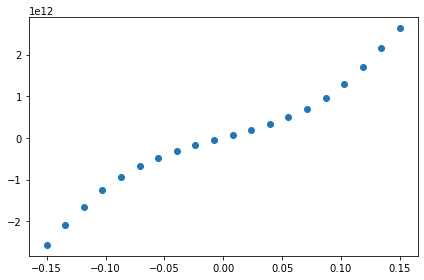

In [229]:
plt.scatter((trans_data[:,0] - data.fermi)/eV, trans_data[:,2])
#plt.axvline(x=eband[1,:].min())
plt.xlabel(r'$E - E_F$  [eV]', fontsize=16)
plt.ylabel(r'density  [1/$cm^2$]', fontsize=16)

plt.tight_layout()
plt.show()

In [230]:
tau_CB_VB = []
for n in range(tausDFTB.shape[0]):
    if ana[n]:
        tmp = []
        for nmus in range(tausDFTB.shape[2]):
            tmp.append(tausDFTB[n,:,nmus].max())
        tau_CB_VB.append(tmp)
        
tau_CB_VB = np.array(tau_CB_VB)

In [205]:
tau_CB_VB.shape

(8, 20)

In [97]:
ana.shape

(8,)

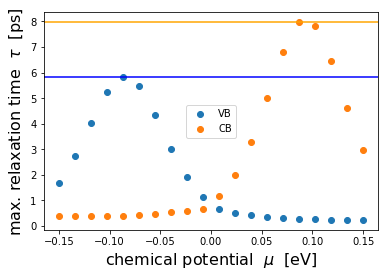

In [231]:
plt.scatter((mus - data.fermi)/eV, tau_CB_VB[ibnd_VB,:], label='VB')
plt.scatter((mus - data.fermi)/eV, tau_CB_VB[ibnd_CB,:], label='CB')

plt.axhline(y=tau_CB_VB[ibnd_VB,:].max(), color='blue')
plt.axhline(y=tau_CB_VB[ibnd_CB,:].max(), color='orange')

plt.xlabel(r'chemical potential  $\mu$  [eV]', fontsize=16)
plt.ylabel(r'max. relaxation time  $\tau$  [ps]', fontsize=16)
plt.legend()
plt.show()
#plt.savefig(basedir +'/el-ph5x5/BT_relaxationtimes.pdf')

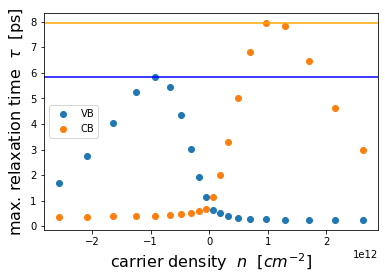

In [232]:
plt.scatter(trans_data[:,2], tau_CB_VB[ibnd_VB,:], label='VB')
plt.scatter(trans_data[:,2], tau_CB_VB[ibnd_CB,:], label='CB')

plt.axhline(y=tau_CB_VB[ibnd_VB,:].max(), color='blue')
plt.axhline(y=tau_CB_VB[ibnd_CB,:].max(), color='orange')

plt.xlabel(r'carrier density  $n$  [$cm^{-2}$]', fontsize=16)
plt.ylabel(r'max. relaxation time  $\tau$  [ps]', fontsize=16)
plt.legend()
plt.show()

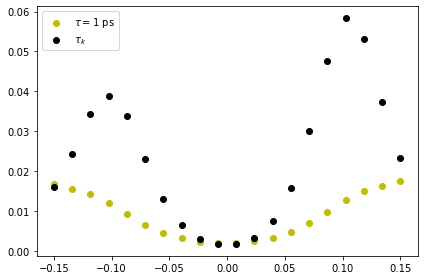

In [233]:
plt.scatter((mus - data.fermi)/eV, Csigma[0,:,0,0]*(data.atoms.cell[2,2]*1e-10) * 1e-12, color="y", label=r'$\tau=1$ ps')
plt.scatter((trans_data[:,0] - data.fermi)/eV, trans_data[:,3], color="k", label=r'$\tau_k$')
#plt.axvline(x=eband[1,:].min())

plt.xlabel(r'chemical potential  $\mu$  [eV]', fontsize=16)
plt.ylabel(r'conductivity  $\sigma_{xx}$  [S]', fontsize=16)

plt.legend()
plt.tight_layout()
plt.show()

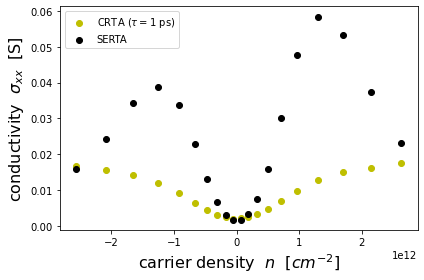

In [234]:
plt.scatter(trans_data[:,2], Csigma[0,:,0,0]*(data.atoms.cell[2,2]*1e-10) * 1e-12, color="y", label=r'CRTA ($\tau=1$ ps)')
plt.scatter(trans_data[:,2], trans_data[:,3], color="k", label=r'SERTA')

plt.xlabel(r'carrier density  $n$  [$cm^{-2}$]', fontsize=16)
plt.ylabel(r'conductivity  $\sigma_{xx}$  [S]', fontsize=16)
plt.legend()
plt.tight_layout()
plt.show()
#plt.savefig(basedir +'/el-ph/BT_conductivity.pdf')

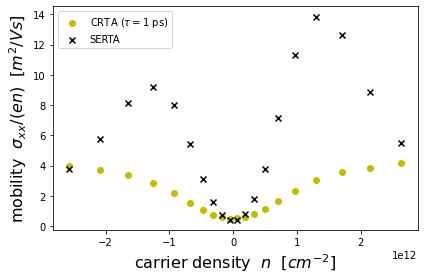

In [235]:
plt.scatter(trans_data[:,2], np.abs( Csigma[0,:,0,0]*(data.atoms.cell[2,2]*1e-10) * 1e-12 / (units.qe_SI*dens*1e4) ), color="y", label=r'CRTA ($\tau=1$ ps)')
plt.scatter(trans_data[:,2], np.abs(  trans_data[:,3] / (units.qe_SI*dens*1e4) ), color="k", label=r'SERTA', marker='x')

#plt.gca().set_xscale('log')
#plt.gca().set_yscale('log')

plt.xlabel(r'carrier density  $n$  [$cm^{-2}$]', fontsize=16)
plt.ylabel(r'mobility  $\sigma_{xx}/(e n)$  [$m^{2}/V s$]', fontsize=16)
plt.legend()
plt.tight_layout()
plt.show()
#plt.savefig(basedir +'/el-ph/BT_mobility.pdf')

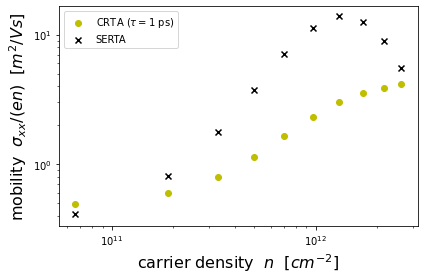

In [236]:
plt.scatter(trans_data[:,2], np.abs( Csigma[0,:,0,0]*(data.atoms.cell[2,2]*1e-10) * 1e-12 / (units.qe_SI*dens*1e4) ), color="y", label=r'CRTA ($\tau=1$ ps)')
plt.scatter(trans_data[:,2], np.abs(  trans_data[:,3] / (units.qe_SI*dens*1e4) ), color="k", label=r'SERTA', marker='x')

plt.gca().set_xscale('log')
plt.gca().set_yscale('log')

plt.xlabel(r'carrier density  $n$  [$cm^{-2}$]', fontsize=16)
plt.ylabel(r'mobility  $\sigma_{xx}/(e n)$  [$m^{2}/V s$]', fontsize=16)
plt.legend()
plt.tight_layout()
plt.show()
#plt.savefig(basedir +'/el-ph/BT_mobility.pdf')